In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Specify a date-parser function based on the Date Format

In [9]:
def parser(s):
    return pd.datetime.strptime(s, '%Y-%m-%d')

In [10]:
df_icecream = pd.read_csv('https://raw.githubusercontent.com/ritvikmath/Time-Series-Analysis/master/ice_cream.csv',
                          index_col=0, parse_dates=True,date_parser=parser)

df_icecream = df_icecream.rename(columns={'IPN31152N':'production'})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [11]:
df_icecream.head()

,production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


## Infer and set the frequency

In [15]:
freq = pd.infer_freq(df_icecream.index)

df_icecream = df_icecream.asfreq(freq)

## First hand visualization

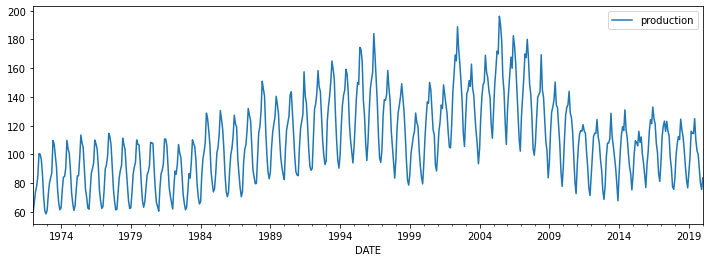

In [17]:
df_icecream.plot(figsize=(12,4))

### Subset data from 2010 onwards for workflow Demo.

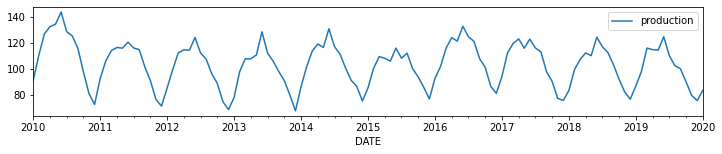

In [19]:
df = df_icecream.loc[pd.to_datetime('2010-01-01') : , :]

df.plot(figsize=(12,2))

### Plot the PACF

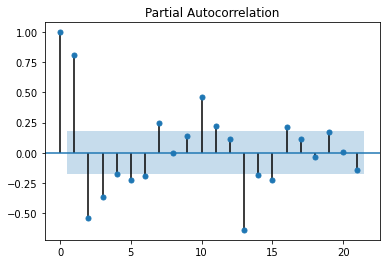

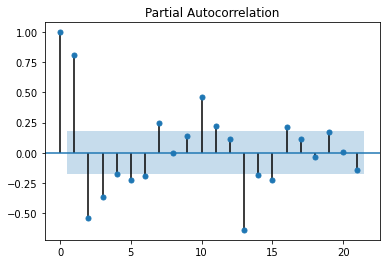

In [21]:
plot_pacf(df['production'])

LAGS : 1 , 2 , 3 , 4, 7, 10 , 13 look good.

## Lets start with AR(3) model

In [22]:
train_end = pd.to_datetime('2018-12-01')


df_train = df.loc[:train_end, :]

df_test = df.loc[train_end:, :]

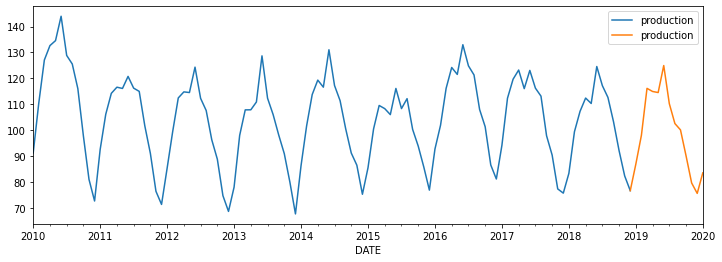

In [25]:
ax = df_train.plot(figsize=(12,4))
df_test.plot(figsize=(12,4), ax=ax)

## Import ARIMA model submodule from Statsmodels and Model ARMA

: ARMA(p , 0) becomes a AR(p) model

In [26]:
from statsmodels.tsa.arima_model import ARMA

In [32]:
model_ar3 = ARMA(df_train, order=(3,0))

In [33]:
model_ar3_fit = model_ar3.fit()

In [34]:
print(model_ar3_fit.summary())

                              ARMA Model Results                              
Dep. Variable:             production   No. Observations:                  108
Model:                     ARMA(3, 0)   Log Likelihood                -374.085
Method:                       css-mle   S.D. of innovations              7.642
Date:                Mon, 11 Jul 2022   AIC                            758.170
Time:                        19:15:14   BIC                            771.580
Sample:                    01-01-2010   HQIC                           763.607
                         - 12-01-2018                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              103.5743      1.809     57.265      0.000     100.029     107.119
ar.L1.production     1.0469      0.088     11.960      0.000       0.875       1.218
ar.L2.production    -0.0523 

ar.L2.production    : p-value = 0.696 >>> 0.05 : Means Lag 2 is highly insignificant and hence can be ignored.

In [37]:
train_end 

Timestamp('2018-12-01 00:00:00')

In [38]:
model_ar3_preds = model_ar3_fit.predict(start=df_test.index[0], end=df_test.index[-1])

residuals_ar3 = df_test['production'] - model_ar3_preds

## Plot the results

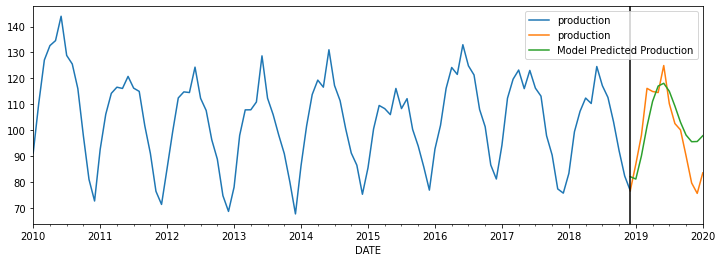

In [45]:
ax = df_train.plot(figsize=(12,4), label='Training Production')
df_test.plot(figsize=(12,4), ax=ax, label='Testing (Actual) Production')
model_ar3_preds.plot(ax=ax, label='Model Predicted Production')

plt.axvline(df_test.index[0], color='k')
plt.legend()

### Plot Results with Forecasts

: We might need to fit the model on entire data for this

In [52]:
df_test.index[0] 

Timestamp('2018-12-01 00:00:00', freq='MS')

In [58]:
future_start = pd.to_datetime('2020-01-01')
future_end = pd.to_datetime('2020-06-01')
model_ar3_full = ARMA(df, order=(3,0))

full_fit = model_ar3_full.fit()
future_preds = full_fit.predict(start=future_start, end=future_end)

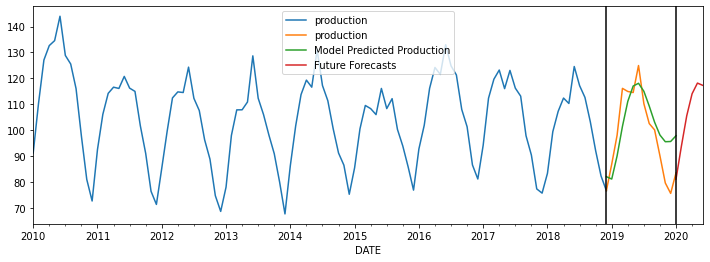

In [59]:
ax = df_train.plot(figsize=(12,4), label='Training Production')
df_test.plot(figsize=(12,4), ax=ax, label='Testing (Actual) Production')
model_ar3_preds.plot(ax=ax, label='Model Predicted Production')
future_preds.plot(ax=ax, label='Future Forecasts')

plt.axvline(df_test.index[0], color='k')
plt.axvline(future_start, color='k')
plt.legend()

## Plot Residuals and conclude weather it is White-Noise or could you have done better?

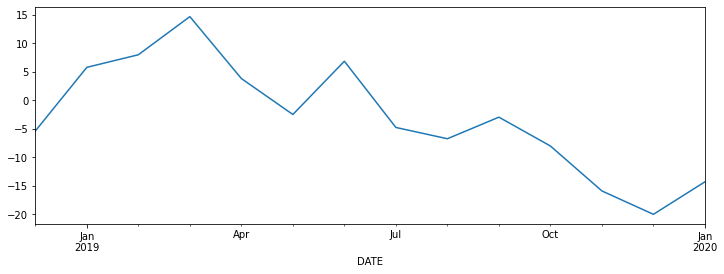

In [62]:
residuals_ar3.plot(figsize=(12,4))

## Conclusions - 

1. Downward Trend : Mean not constant. 
2. Variability isnt consistent. 

> Not White Noise. Hence we could have done better in the model, but good enough for workflow explanation